# 

In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(recipes)
options(repr.matrix.max.rows = 6)

In [21]:
PLAYERS_DATA_URL = "https://raw.githubusercontent.com/Bumblet3a/dsci-individual-project/refs/heads/main/players.csv"
SESSION_DATA_URL = "https://raw.githubusercontent.com/Bumblet3a/dsci-individual-project/refs/heads/main/sessions.csv"

download.file(PLAYERS_DATA_URL, "players.csv")
download.file(SESSION_DATA_URL, "sessions.csv")

players <- read_csv("players.csv")
head(players)
sessions_data <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
player_sessions <- merge(sessions_data, players, all = TRUE)|>
select(Age, experience, subscribe, played_hours)|>
drop_na(Age:played_hours)

player_sessions

Age,experience,subscribe,played_hours
<dbl>,<chr>,<lgl>,<dbl>
20,Regular,TRUE,1.5
20,Regular,TRUE,1.5
17,Veteran,TRUE,0.0
⋮,⋮,⋮,⋮
23,Amateur,TRUE,56.1
17,Amateur,TRUE,0.1
20,Beginner,TRUE,1.1


In [51]:
players_scaled <- player_sessions|>
mutate(Age = scale(Age, center = TRUE),
       played_hours = scale(played_hours, center = TRUE))
players_scaled

Age,experience,subscribe,played_hours
"<dbl[,1]>",<chr>,<lgl>,"<dbl[,1]>"
0.1270154,Regular,TRUE,-1.122151
0.1270154,Regular,TRUE,-1.122151
-0.5043878,Veteran,TRUE,-1.140283
⋮,⋮,⋮,⋮
0.7584187,Amateur,TRUE,-0.4621379
-0.5043878,Amateur,TRUE,-1.1390740
0.1270154,Beginner,TRUE,-1.1269858


In [52]:
players_split <- initial_split(players_scaled, prop = 0.75, strata = subscribe)
players_testing <- testing(players_split)
players_training <- training(players_split)

In [53]:

#players_model <- nearest_neighbor(weight_func = "rectangular",
    #              neighbors = tune()) |>
   #             set_engine("kknn") |>
  #              set_mode("regression")

#play_recipe <- recipe(played_hours ~ ., data = players_training) |>
 #step_scale(Age) |>
 #step_center(Age)

#play_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

#play_workflow <- workflow() |>
#add_recipe(play_recipe) |>
#add_model(players_model)

#gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 10))

#play_results <- tune_grid(
  #play_workflow,
  #resamples = play_vfold,
  #grid = gridvals) |>
  #collect_metrics()

#play_results


In [56]:
#azumi testing code cell 
#works
players_training <- players_training |>
  mutate(played_hours = as.numeric(played_hours))

players_recipe <- recipe(played_hours ~ Age + experience + subscribe, data = players_training) |>
  step_dummy(experience) |>
  step_mutate(subscribe = as.numeric(subscribe)) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())


players_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune())|>
                set_engine("kknn")|>
                set_mode("regression")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

players_wf <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_spec)
players_wf


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_dummy()
• step_mutate()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [57]:
#azumi testing code cell
#works
players_gridvals <- tibble (neighbors = seq(1, 81))

players_multi <- players_wf|>
tune_grid(players_vfold, grid = players_gridvals)|>
collect_metrics()|>
filter(.metric == "rmse")|>
filter(mean == min(mean))

players_k <- players_multi|>
pull(neighbors)
players_k
# number returned is 36?               

[1] 36

In [60]:
#azumi testing code cell
#works
players_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = players_k)|>
set_engine("kknn")|>
set_mode("regression")

knn_players_fit <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_spec)|>
fit(data = players_training)|>
predict(players_training)|>
bind_cols(players_training)

knn_players_met <- metrics(knn_players_fit, truth = played_hours, 
                           estimate = .pred)|>
                    filter(.metric == "rmse")
knn_players_met

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.4371096


In [64]:
play_min <- play_results|>
filter(.metric == "rmse")|>
slice_min(mean, n = 1)
play_min

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `.metric == "rmse"`.
[1mCaused by error:[22m
[33m![39m object '.metric' not found


In [38]:
players_pred_accuracy <- players_prediction|>
metrics(truth = subscribe, estimate = .pred_class)
players_pred_accuracy

ERROR: Error in eval(expr, envir, enclos): object 'players_prediction' not found


In [39]:
players_mat <- players_prediction|>
conf_mat(truth = subscribe, estimate = .pred_class)
players_mat

ERROR: Error in eval(expr, envir, enclos): object 'players_prediction' not found


In [40]:
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)


players_resample <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_model)|>
fit_resamples(resamples = players_vfold)|>
collect_metrics()
players_resample

ERROR: [1m[33mError[39m:[22m
[33m![39m 1 argument has been tagged for tuning in this component: model_spec. 
Please use one of the tuning functions (e.g. `tune_grid()`) to optimize them.


In [59]:
players_tune <-  nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("regression")

play_fit <- workflow()|>
add_recipe(play_recipe)|>
add_model(play_spec)|>
fit(data = play_sessions_training)

players_tune_results <- workflow()|>
add_recipe(players_recipe)|>
add_model(players_tune)|>
tune_grid(resamples = players_vfold, grid = players_grid)|>
collect_metrics()
players_tune_results

ERROR: Error in eval(expr, envir, enclos): object 'play_spec' not found


In [42]:
sessions <- sessions_data |>
    separate(start_time, into = c("Date", "Time"), sep = " ") |>
    separate(Date, into = c("Day", "Month", "Year"), sep = "/") |>
    separate(end_time, into = c("EDate", "ETime"), sep = " ") |>
    separate(EDate, into = c("EDay", "EMonth", "EYear"), sep = "/") |>
    mutate(Day = as.numeric(Day), EDay = as.numeric(EDay),
           Month = as.numeric(Month), EMonth = as.numeric(EMonth), 
           Year = as.numeric(Year), EYear = as.numeric(EYear)) |>
    separate(Time, into = c("Hour", "Minute"), sep = ":") |>
    separate(ETime, into = c("EHour", "EMinute"), sep = ":") |>
    mutate(Hour = as.numeric(Hour), EHour = as.numeric(EHour),
           Minute = as.numeric(Minute), EMinute = as.numeric(EMinute)) |>

    #Filter out rows that contain sessions that lasted more than a day(these data points are probably outliers)

    filter(Day==EDay & Month==EMonth & Year==EYear)



sessions

hashedEmail,Day,Month,Year,Hour,Minute,EDay,EMonth,EYear,EHour,EMinute,original_start_time,original_end_time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,6,2024,18,12,30,6,2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,6,2024,23,33,17,6,2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,7,2024,17,34,25,7,2024,17,57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28,7,2024,15,36,28,7,2024,15,57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25,7,2024,6,15,25,7,2024,6,22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20,5,2024,2,26,20,5,2024,2,45,1.71617e+12,1.71617e+12


average_time,median_time,sd_time
<dbl>,<dbl>,<dbl>
46.85982,26,51.73255


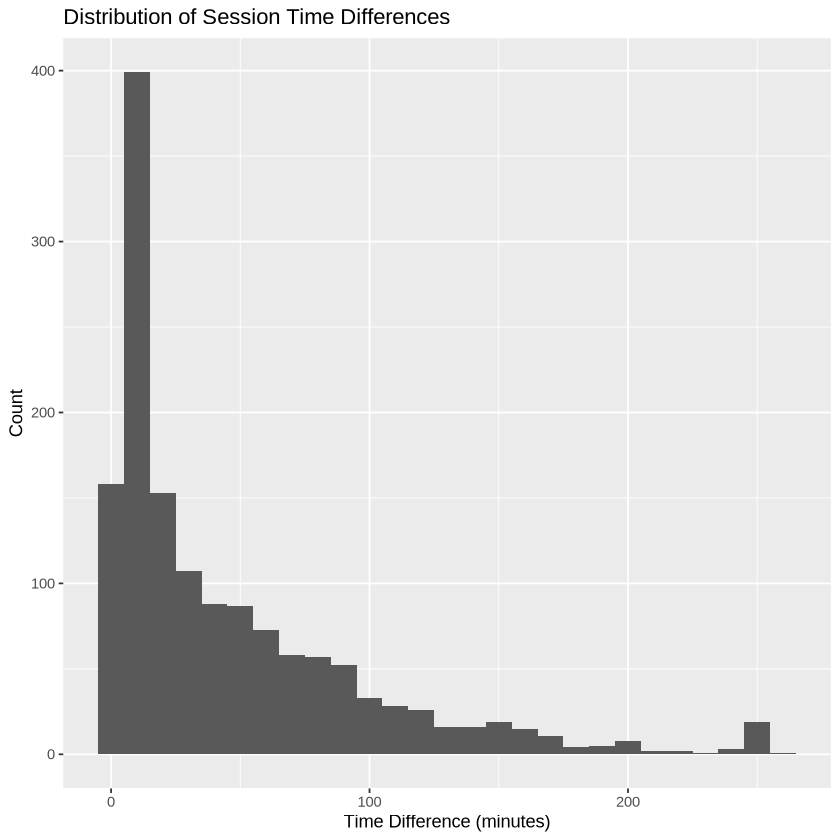

In [28]:
sessions_time_diff <- sessions |>
    mutate(time_diff = (EHour - Hour) * 60 + (EMinute - Minute))


time_stats <- sessions_time_diff |>
    summarize(average_time = mean(time_diff, na.rm = TRUE),
              median_time = median(time_diff, na.rm = TRUE),
              sd_time = sd(time_diff, na.rm = TRUE))


sessions_visualization <- sessions_time_diff |>
    ggplot(aes(x = time_diff)) +
    geom_histogram(binwidth = 10) +
    labs(title = "Distribution of Session Time Differences",
         x = "Time Difference (minutes)",
         y = "Count")

sessions_visualization
time_stats

# Skewed right distribution where most people had sessions that lasted less than 60 minutes

## Sessions Data Analysis

# Distribution Plot:
To create a distribution plot that visualizes the time differences in players' sessions, a new data frame was created with a column that calculates the time length of sessions by finding the difference between the start and ending hours, multiplying by 60, and adding the difference between the start and ending minutes. By using this column as the x-axis of a historgram with counts on the y-axis, the distribution of the length of player time sessions can be seen. The histogram depicts a skewed right distribution that has a mean play time of around 46 minutes, median time of 26 minutes, and standard deviation of 51 minutes. This large difference between the mean and median values of session time indicates that a majority of session times lie under 30 minutes, while large outlier session times are influencing the mean by increasing the overall average for the session times.